# Compare COVID-19 data for a number of countries
### Source of data is wikipedia.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_scraper as ds

In [2]:
def get_data(download=False):
    if download:
        all_countries = ds.wiki_shortcodes.keys()
        df = ds.download_data(all_countries)
        df.to_pickle('wikipedia_data.pickle')
        return df
    return pd.read_pickle('wikipedia_data.pickle')


def filter_columns(df, start_string):
    """Return list of columns in dataframe that start with start_string."""
    return [col for col in df.columns if col.startswith(start_string)]


def rename_columns(old_names):
    """Return dictionary with old column names as keys and new ones as values."""
    new_names = {}
    for col in old_names:
        new_names[col] = ds.country_names[col[-2:]]
    return new_names


def start_indices(df, threshold, num_type='int64'):
    """
    For each numeric column in dataframe find index of row where value is
    equal or above threshold. Return as dictionary.
    """
    numeric_columns = df.select_dtypes(num_type).columns
    start_indices = {}
    for col in numeric_columns:
        indices = df[df[col] >= threshold].index
        start_indices[col] = indices[0]
    return start_indices


def growth_table(df, threshold):
    """
    Generate dataframe with cases/deaths by country. Only select rows where total
    is above threshold. Reindex the data for each country before adding to
    dataframe, which enables comparing growth in countries from the same base.
    For example start table from when each country had >= 10 deaths.
    """
    indices = start_indices(df, threshold)
    countries = list(indices.keys())
    base_country = countries[0]
    frame = pd.DataFrame(df.loc[indices[base_country]:, base_country])
    frame = frame.reset_index(drop=True)
    for country in countries[1:]:
        frame2 = pd.DataFrame(df.loc[indices[country]:, country])
        frame2 = frame2.reset_index(drop=True)
        frame = frame.merge(frame2, how='outer', left_index=True, right_index=True)
    # replace remaining 0 with nan (for example, UK often report deaths day later)
    frame = frame.replace(0, np.nan)
    return frame

In [3]:
# all_countries = ds.wiki_shortcodes.keys()
# all_countries

In [4]:
wiki_data = get_data()

In [5]:
# create list of required columns for deaths dataframe
deaths_cols = ['date'] + filter_columns(wiki_data, 'deaths')
# create deaths dataframe
deaths_raw = wiki_data.loc[:, deaths_cols]
# create disctionary with new column names
new_column_names = rename_columns(deaths_raw.columns[1:])
# rename columns
deaths_raw = deaths_raw.rename(columns=new_column_names)
deaths_raw

,date,austria,belgium,denmark,france,germany,italy,japan,netherlands,ny_state,south_korea,spain,uk,us
0,2020-01-21,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2020-04-06,220,1632,187,8911,1434,16523,92,1867,4758,192,13341,6159,10746
77,2020-04-07,243,2035,203,10328,1607,17127,93,2101,5489,200,14045,7097,12674
78,2020-04-08,273,2240,218,10869,1861,17669,94,2248,6268,204,14792,7978,14610
79,2020-04-09,295,2523,237,12210,2107,18279,99,2396,7067,208,15447,8958,16466


In [6]:
start_value = 2
deaths = growth_table(deaths_raw, start_value)

In [7]:
deaths

,austria,belgium,denmark,france,germany,italy,japan,netherlands,ny_state,south_korea,spain,uk,us
0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2,2.0,2.0,2.0
1,3.0,3.0,4.0,2.0,2.0,3.0,4.0,4.0,3.0,2,2.0,2.0,6.0
2,4.0,3.0,5.0,4.0,3.0,6.0,5.0,4.0,7.0,4,3.0,3.0,9.0
3,6.0,4.0,6.0,4.0,5.0,10.0,5.0,5.0,12.0,7,8.0,5.0,11.0
4,6.0,4.0,9.0,7.0,8.0,12.0,6.0,5.0,16.0,10,10.0,6.0,11.0
5,8.0,5.0,14.0,9.0,8.0,17.0,6.0,10.0,38.0,12,17.0,8.0,14.0
6,16.0,5.0,18.0,16.0,12.0,21.0,6.0,12.0,46.0,13,30.0,8.0,19.0
7,21.0,14.0,21.0,21.0,12.0,29.0,6.0,20.0,58.0,13,36.0,10.0,21.0
8,28.0,21.0,24.0,25.0,12.0,34.0,6.0,24.0,76.0,17,55.0,21.0,26.0
9,31.0,37.0,24.0,33.0,12.0,52.0,6.0,43.0,157.0,22,86.0,35.0,31.0


In [8]:
max_row = deaths.netherlands.idxmax()
graph_countries = ['france', 'netherlands', 'uk', 'italy', 'spain', 'ny_state']
deaths_log = np.log10(deaths.loc[:max_row, graph_countries])
deaths_log

,france,netherlands,uk,italy,spain,ny_state
0,0.301030,0.477121,0.301030,0.301030,0.301030,0.301030
1,0.301030,0.602060,0.301030,0.477121,0.301030,0.477121
2,0.602060,0.602060,0.477121,0.778151,0.477121,0.845098
3,0.602060,0.698970,0.698970,1.000000,0.903090,1.079181
4,0.845098,0.698970,0.778151,1.079181,1.000000,1.204120
5,0.954243,1.000000,0.903090,1.230449,1.230449,1.579784
6,1.204120,1.079181,0.903090,1.322219,1.477121,1.662758
7,1.322219,1.301030,1.000000,1.462398,1.556303,1.763428
8,1.397940,1.380211,1.322219,1.531479,1.740363,1.880814
9,1.518514,1.633468,1.544068,1.716003,1.934498,2.195900


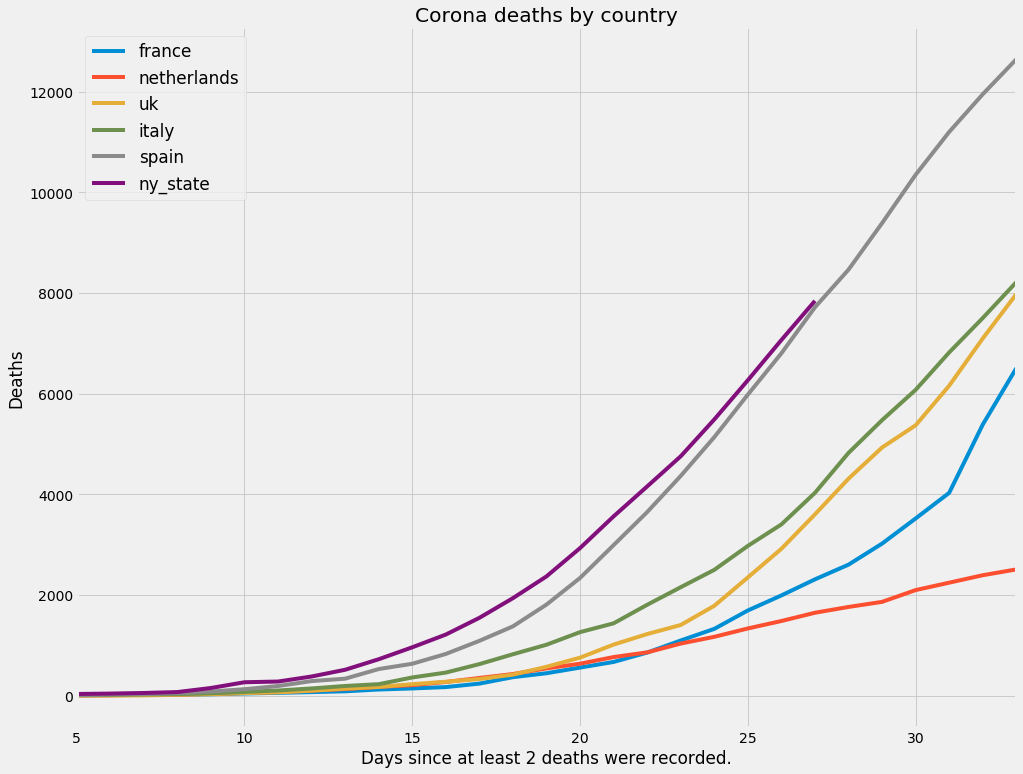

In [9]:
plt.style.use('fivethirtyeight')

graph_data = deaths.loc[5: max_row, graph_countries]

fig, ax = plt.subplots(figsize=(15, 12))
graph_data.plot(kind='line', y=graph_data.columns, use_index=True, ax=ax)
x_label = f'Days since at least {start_value} deaths were recorded.'
ax.set(title='Corona deaths by country', xlabel=x_label, ylabel='Deaths')
ax.legend(loc='upper left', fontsize='large');

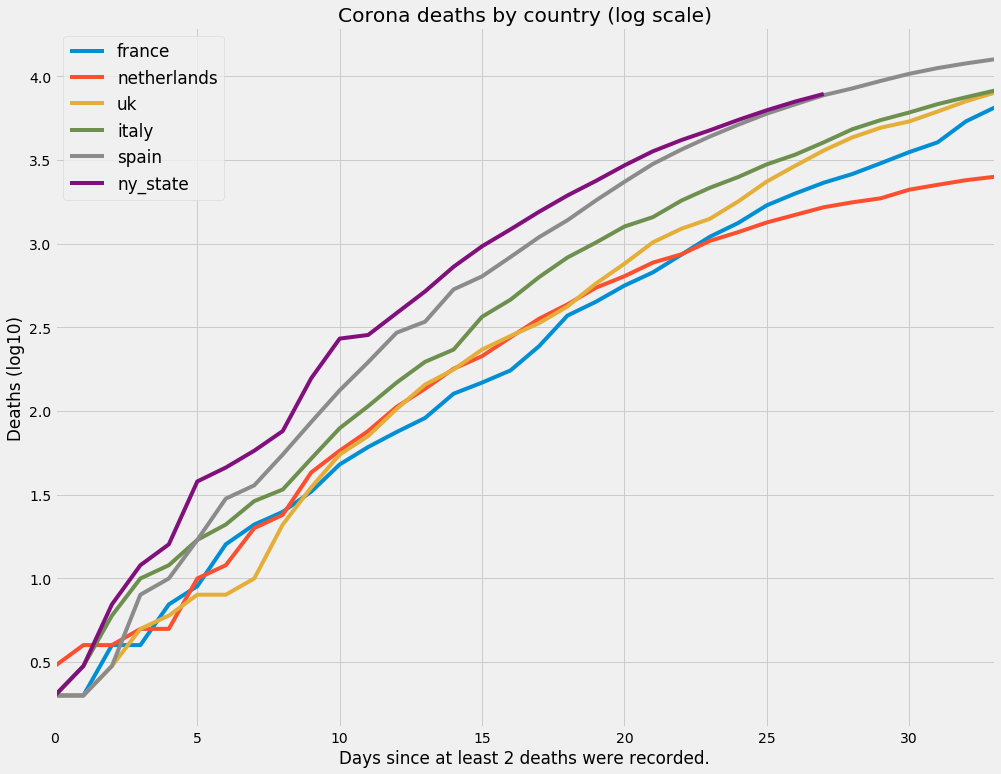

In [10]:
fig2, ax2 = plt.subplots(figsize=(15, 12))
deaths_log.plot(kind='line', y=deaths_log.columns, use_index=True, ax=ax2)
ax2.set(title='Corona deaths by country (log scale)', xlabel=x_label, ylabel='Deaths (log10)')
ax2.legend(loc='upper left', fontsize='large');